In [ ]:
#Import the google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


# Task 1 - Canny Edge Detection


#Step 1 - Import image from google drive



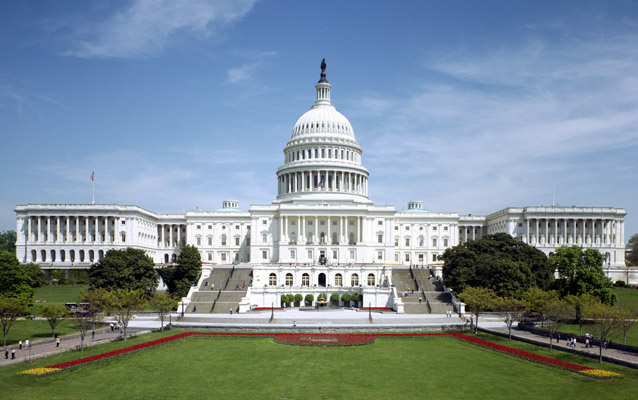

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
from matplotlib import pyplot as plt


# Read an image from the Drive
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/Capitol.jpg')
image = cv2.resize(image, (638, 400)) #Resized to the correct dimensions


# show the image
cv2_imshow(image) ## use cv2.imshow("My Image", image) when you run the code locally

#Convert to grayscale

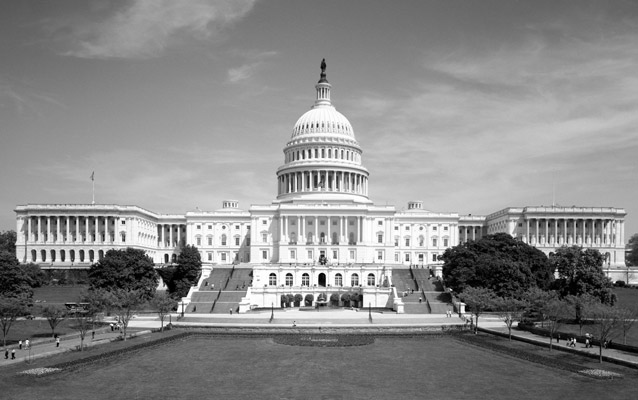

In [ ]:
# convert the image to grayscale
output = image.copy()
gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

#Apply a Gaussian Blur

Use the built in cv2.GaussianBlur() kernel to blur the image. This will reduce noise thus making it easier to distinguish edges.

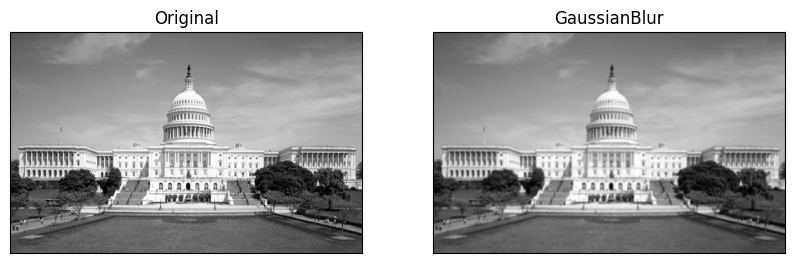

In [ ]:
img = gray.copy()

blur = cv2.GaussianBlur(img,(5,5),0) #Using the gaussian kernel we apply the filter

plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(121),plt.imshow(img,cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur, cmap = 'gray'),plt.title('GaussianBlur')
plt.xticks([]), plt.yticks([])
plt.show()

#Compute the Intensity of the gradient using Sobel x and y filters

With the help of sobel filters, we are able to calculate the gradient magnitude and the gradient direction. We need these values because they highlight the changes in pixel intensity on the x and y axis, changes in pixel intensities signify an edge is present.

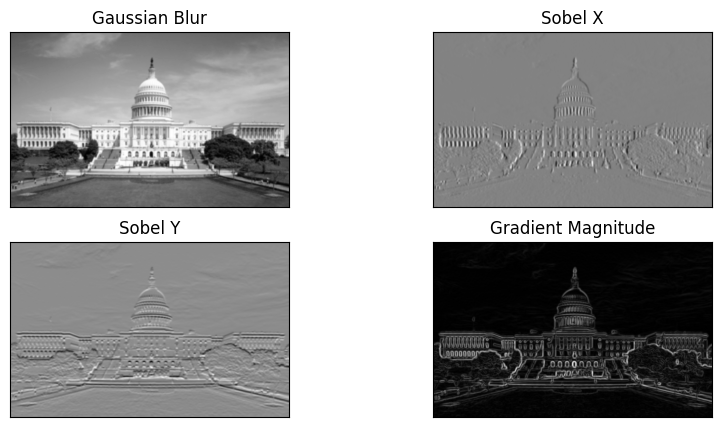

In [ ]:
img = blur.copy() #Using gaussian blur

sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
gradient_magnitude = np.sqrt(np.square(sobelx) + np.square(sobely)) #Calculate the gradient magnitude
gradient_direction = np.arctan2(sobely, sobelx) * 180 / np.pi  #Calculate the gradient direction and convert to degrees


#Display results
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Gaussian Blur'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4),plt.imshow(gradient_magnitude, cmap = 'gray')
plt.title('Gradient Magnitude'),plt.xticks([]), plt.yticks([]),
plt.show()

#Non maximum Suppression

The output from our gradient magnitude shows many edges, however we want to see thinner lines. To achieve the desired output, we create a matrix that stores the values of the gradient intensity we found previously. We compare each pixel to its neighbor in the same edge direction and keep the maximum value.



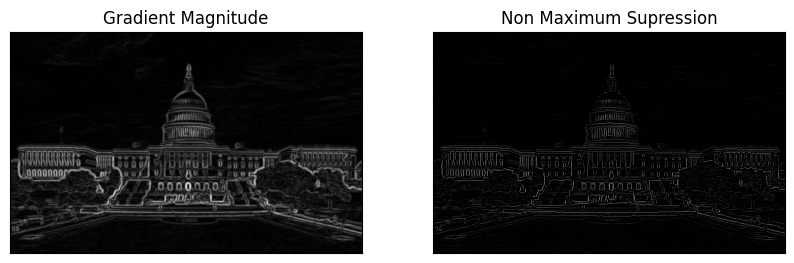

In [ ]:
def non_max_suppression(gradient_magnitude, gradient_direction):
      M, N = gradient_magnitude.shape
      output = np.zeros((M, N), dtype=np.float32)
      angle = gradient_direction % 180  # Normalize angles to [0, 180]

      for i in range(1, M-1):
          for j in range(1, N-1):
              q, r = 255, 255

              # Check gradient direction and compare with neighboring pixels

              #angle 0
              if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                  q = gradient_magnitude[i, j+1]
                  r = gradient_magnitude[i, j-1]
              #angle 45
              elif 22.5 <= angle[i, j] < 67.5:
                  q = gradient_magnitude[i+1, j-1]
                  r = gradient_magnitude[i-1, j+1]
              #angle 90
              elif 67.5 <= angle[i, j] < 112.5:
                  q = gradient_magnitude[i+1, j]
                  r = gradient_magnitude[i-1, j]
              #angle 135
              elif 112.5 <= angle[i, j] < 157.5:
                  q = gradient_magnitude[i-1, j-1]
                  r = gradient_magnitude[i+1, j+1]

              if gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r:
                  output[i, j] = gradient_magnitude[i, j]
              else:
                  output[i, j] = 0

      return output

#Source towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123.

non_max_suppressed = non_max_suppression(gradient_magnitude, gradient_direction)

plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(121),plt.imshow(gradient_magnitude, cmap = 'gray'),
plt.title('Gradient Magnitude'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(non_max_suppressed, cmap = 'gray'),
plt.title('Non Maximum Supression'), plt.xticks([]), plt.yticks([])
plt.show()

#Double Thresholding

The strong pixels signify pixels that are sure to be in the final edge, weak pixels are used to identify pixels with intensities lower than the threshold are considered irrelevant and not added. This results in pixels only having 2 values: high or low.

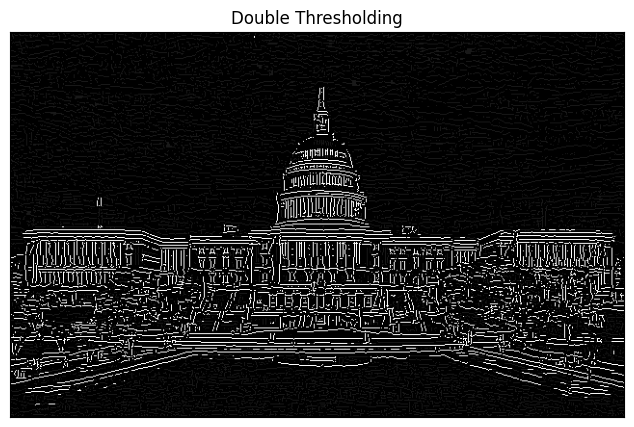

In [ ]:
def double_threshold(img, lowThresholdRatio, highThresholdRatio):

    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = 25
    strong = 255

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res
# Via https://medium.com/@rohit-krishna/coding-canny-edge-detection-algorithm-from-scratch-in-python-232e1fdceac7

thresholded = double_threshold(non_max_suppressed, 0.05, 0.09)

plt.imshow(thresholded, cmap = 'gray')
plt.title('Double Thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

#Edge Tracking by Hysterisis

Goes through a matrix, if the pointer is at a weak pixel, it checks if any of the 8 neighboring pixels around it is a strong pixel. If yes, the weak pixel becomes a strong pixel.

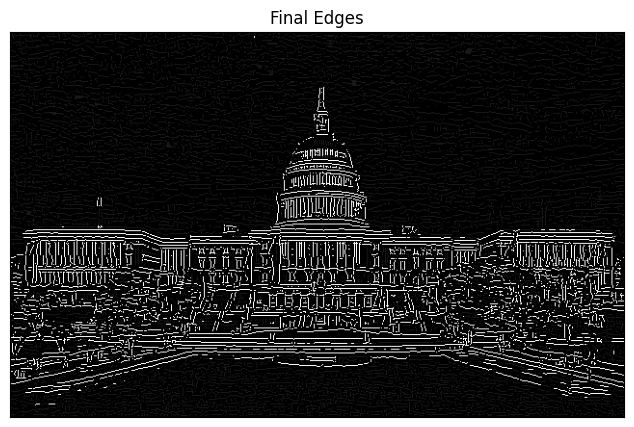

In [ ]:
def hysteresis(image, weak=75, strong=255):
    M, N = image.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if image[i, j] == weak:
                # Check if any of the 8 neighboring pixels is strong
                if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or
                    (image[i+1, j+1] == strong) or (image[i, j-1] == strong) or
                    (image[i, j+1] == strong) or (image[i-1, j-1] == strong) or
                    (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

# With the help of https://medium.com/@rohit-krishna/coding-canny-edge-detection-algorithm-from-scratch-in-python-232e1fdceac7

final_edges = hysteresis(thresholded)

plt.imshow(final_edges, cmap = 'gray')
plt.title('Final Edges'), plt.xticks([]), plt.yticks([])
plt.show()

#Comparison with the cv2.Canny() function

As we can see the cv2.Canny() function has much clearer and intricate edges. As well as it focusing on the building, and not the clouds in the sky as well.

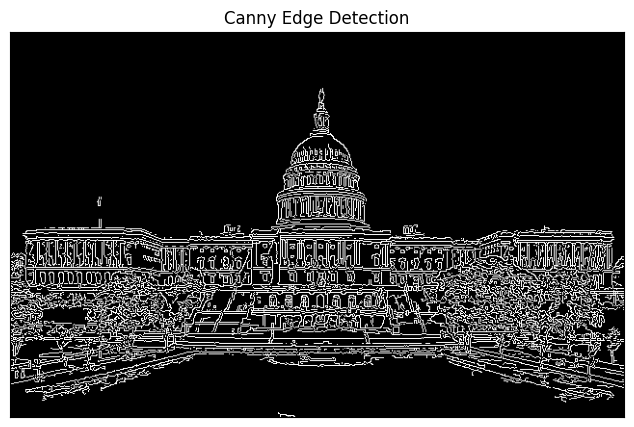

In [ ]:
Canny = cv2.Canny(gray, 50, 150)
plt.imshow(Canny, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])
plt.show()

# Step 2 - Testing

In this part, I will try different thresholds and filters starting from the Gaussian blur. My goal is to try and remove some unnecessary edges, notably the clouds and in the grass.

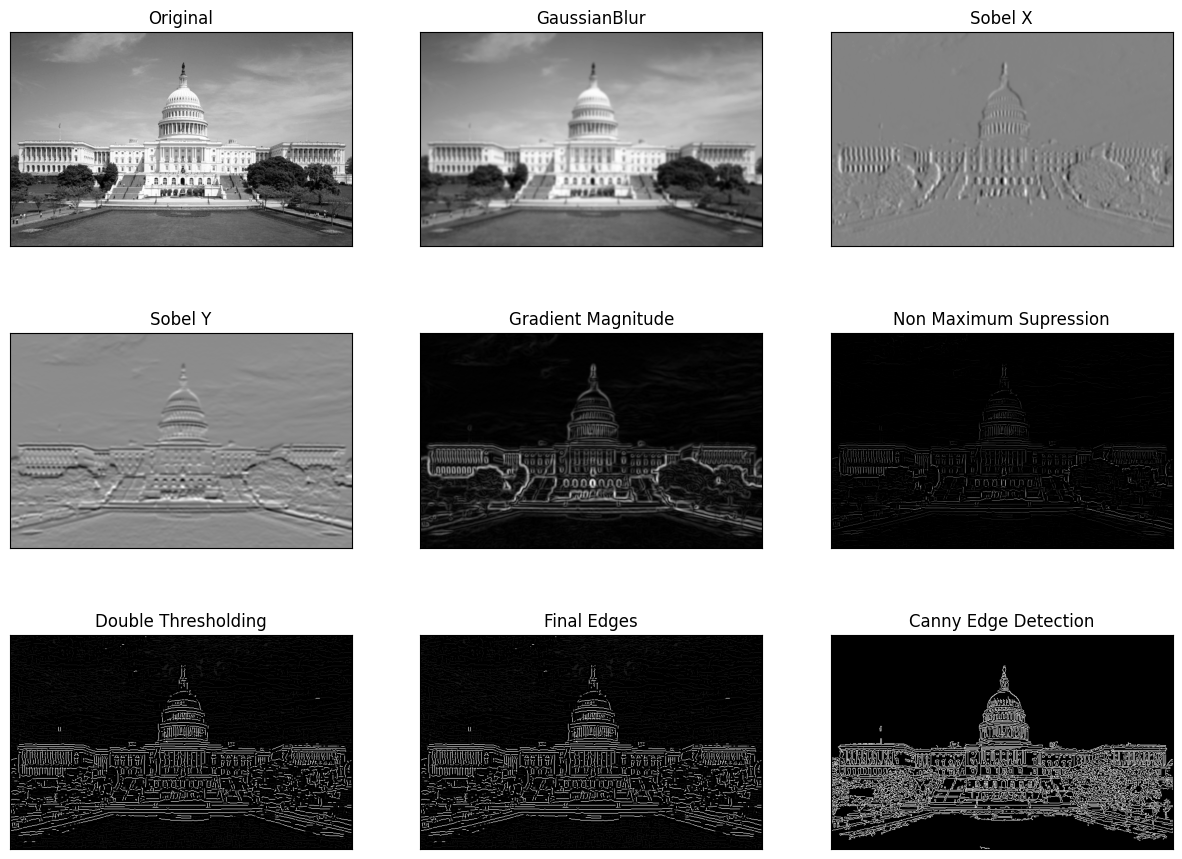

In [ ]:
img2 = gray.copy()

blur2 = cv2.GaussianBlur(img2,(9,9),0) #Increased the blur compared the first try

sobelx2 = cv2.Sobel(blur2,cv2.CV_64F,1,0,ksize=5)
sobely2 = cv2.Sobel(blur2,cv2.CV_64F,0,1,ksize=5)
gradient_magnitude2 = np.sqrt(np.square(sobelx2) + np.square(sobely2))
gradient_direction2 = np.arctan2(sobely2, sobelx2) * 180 / np.pi
non_max_suppressed2 = non_max_suppression(gradient_magnitude2, gradient_direction2)
thresholded2 = double_threshold(non_max_suppressed2, 0.05, 0.09)
final_edges2 = hysteresis(thresholded2)

plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(431),plt.imshow(img2,cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(432),plt.imshow(blur2, cmap = 'gray'),plt.title('GaussianBlur')
plt.xticks([]), plt.yticks([])
plt.subplot(433),plt.imshow(sobelx2,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(434),plt.imshow(sobely2,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(435),plt.imshow(gradient_magnitude2, cmap = 'gray')
plt.title('Gradient Magnitude'),plt.xticks([]), plt.yticks([])
plt.subplot(436),plt.imshow(non_max_suppressed2, cmap = 'gray')
plt.title('Non Maximum Supression'),plt.xticks([]), plt.yticks([])
plt.subplot(437), plt.imshow(thresholded2, cmap = 'gray')
plt.title('Double Thresholding'), plt.xticks([]), plt.yticks([])
plt.subplot(438), plt.imshow(final_edges2, cmap = 'gray')
plt.title('Final Edges'), plt.xticks([]), plt.yticks([])
plt.subplot(439),plt.imshow(Canny, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])
plt.show()

#Test 2

Change the thresholds in the non maximum suppression

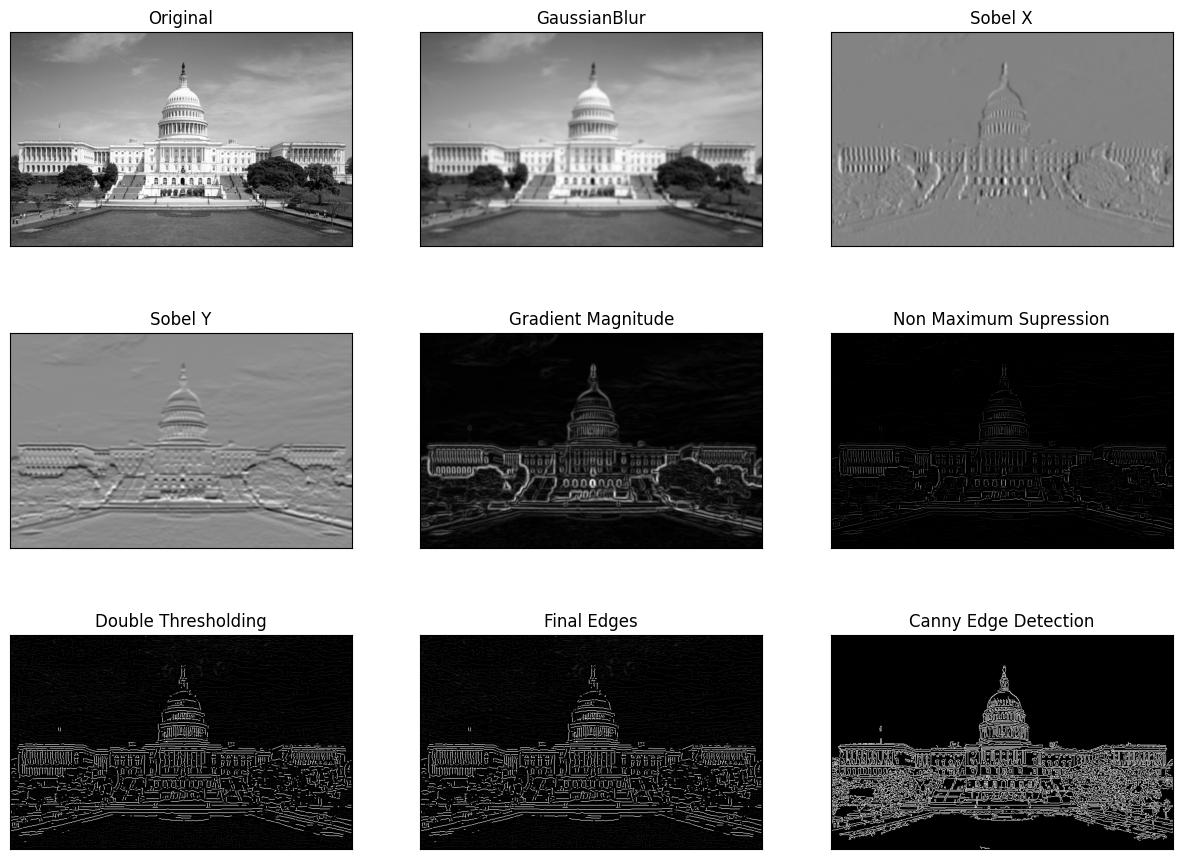

In [ ]:
img3 = gray.copy()

blur3 = cv2.GaussianBlur(img3,(9,9),0)

sobelx3 = cv2.Sobel(blur3,cv2.CV_64F,1,0,ksize=5)
sobely3 = cv2.Sobel(blur3,cv2.CV_64F,0,1,ksize=5)
gradient_magnitude3 = np.sqrt(np.square(sobelx3) + np.square(sobely3))
gradient_direction3 = np.arctan2(sobely3, sobelx3) * 180 / np.pi
non_max_suppressed3 = non_max_suppression(gradient_magnitude3, gradient_direction3)
thresholded3 = double_threshold(non_max_suppressed3, 0.06, 0.1) #Increased both values by 0.01
final_edges3 = hysteresis(thresholded3)

plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(431),plt.imshow(img3,cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(432),plt.imshow(blur3, cmap = 'gray'),plt.title('GaussianBlur')
plt.xticks([]), plt.yticks([])
plt.subplot(433),plt.imshow(sobelx3,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(434),plt.imshow(sobely3,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(435),plt.imshow(gradient_magnitude3, cmap = 'gray')
plt.title('Gradient Magnitude'),plt.xticks([]), plt.yticks([])
plt.subplot(436),plt.imshow(non_max_suppressed3, cmap = 'gray')
plt.title('Non Maximum Supression'),plt.xticks([]), plt.yticks([])
plt.subplot(437), plt.imshow(thresholded3, cmap = 'gray')
plt.title('Double Thresholding'), plt.xticks([]), plt.yticks([])
plt.subplot(438), plt.imshow(final_edges3, cmap = 'gray')
plt.title('Final Edges'), plt.xticks([]), plt.yticks([])
plt.subplot(439),plt.imshow(Canny, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])
plt.show()

#Test 3

Use averaging instead of Gaussian blur

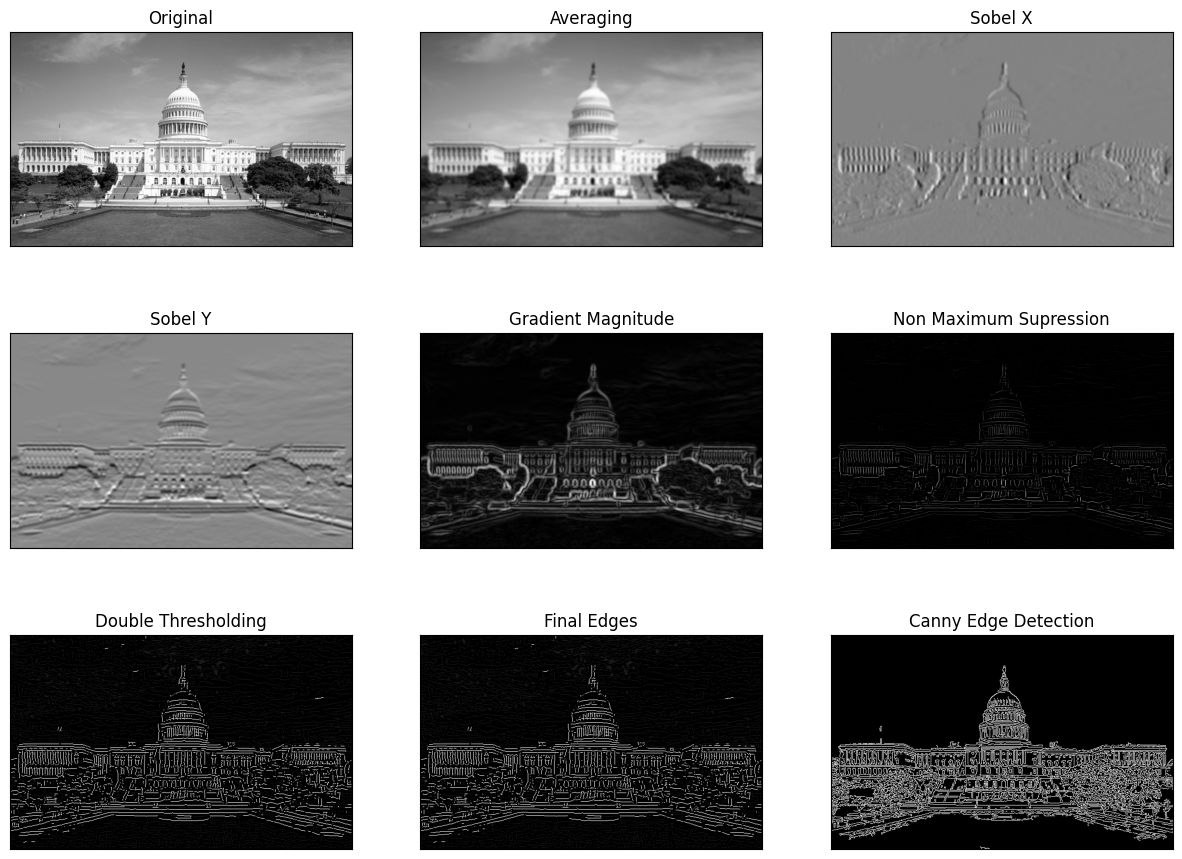

In [ ]:
img4 = gray.copy()

kernel = np.ones((5,5),np.float32)/25 # define the kernel/filter
dst = cv2.filter2D(img,-1,kernel)     # apply the filter

sobelx4 = cv2.Sobel(dst,cv2.CV_64F,1,0,ksize=5)
sobely4 = cv2.Sobel(dst,cv2.CV_64F,0,1,ksize=5)
gradient_magnitude4 = np.sqrt(np.square(sobelx4) + np.square(sobely4))
gradient_direction4 = np.arctan2(sobely4, sobelx4) * 180 / np.pi
non_max_suppressed4 = non_max_suppression(gradient_magnitude4, gradient_direction4)
thresholded4 = double_threshold(non_max_suppressed4, 0.05, 0.09)
final_edges4 = hysteresis(thresholded4)

plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(431),plt.imshow(img4,cmap = 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(432),plt.imshow(dst, cmap = 'gray'),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.subplot(433),plt.imshow(sobelx4,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(434),plt.imshow(sobely4,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(435),plt.imshow(gradient_magnitude4, cmap = 'gray')
plt.title('Gradient Magnitude'),plt.xticks([]), plt.yticks([])
plt.subplot(436),plt.imshow(non_max_suppressed4, cmap = 'gray')
plt.title('Non Maximum Supression'),plt.xticks([]), plt.yticks([])
plt.subplot(437), plt.imshow(thresholded4, cmap = 'gray')
plt.title('Double Thresholding'), plt.xticks([]), plt.yticks([])
plt.subplot(438), plt.imshow(final_edges4, cmap = 'gray')
plt.title('Final Edges'), plt.xticks([]), plt.yticks([])
plt.subplot(439),plt.imshow(Canny, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])
plt.show()

#Side by side comparison

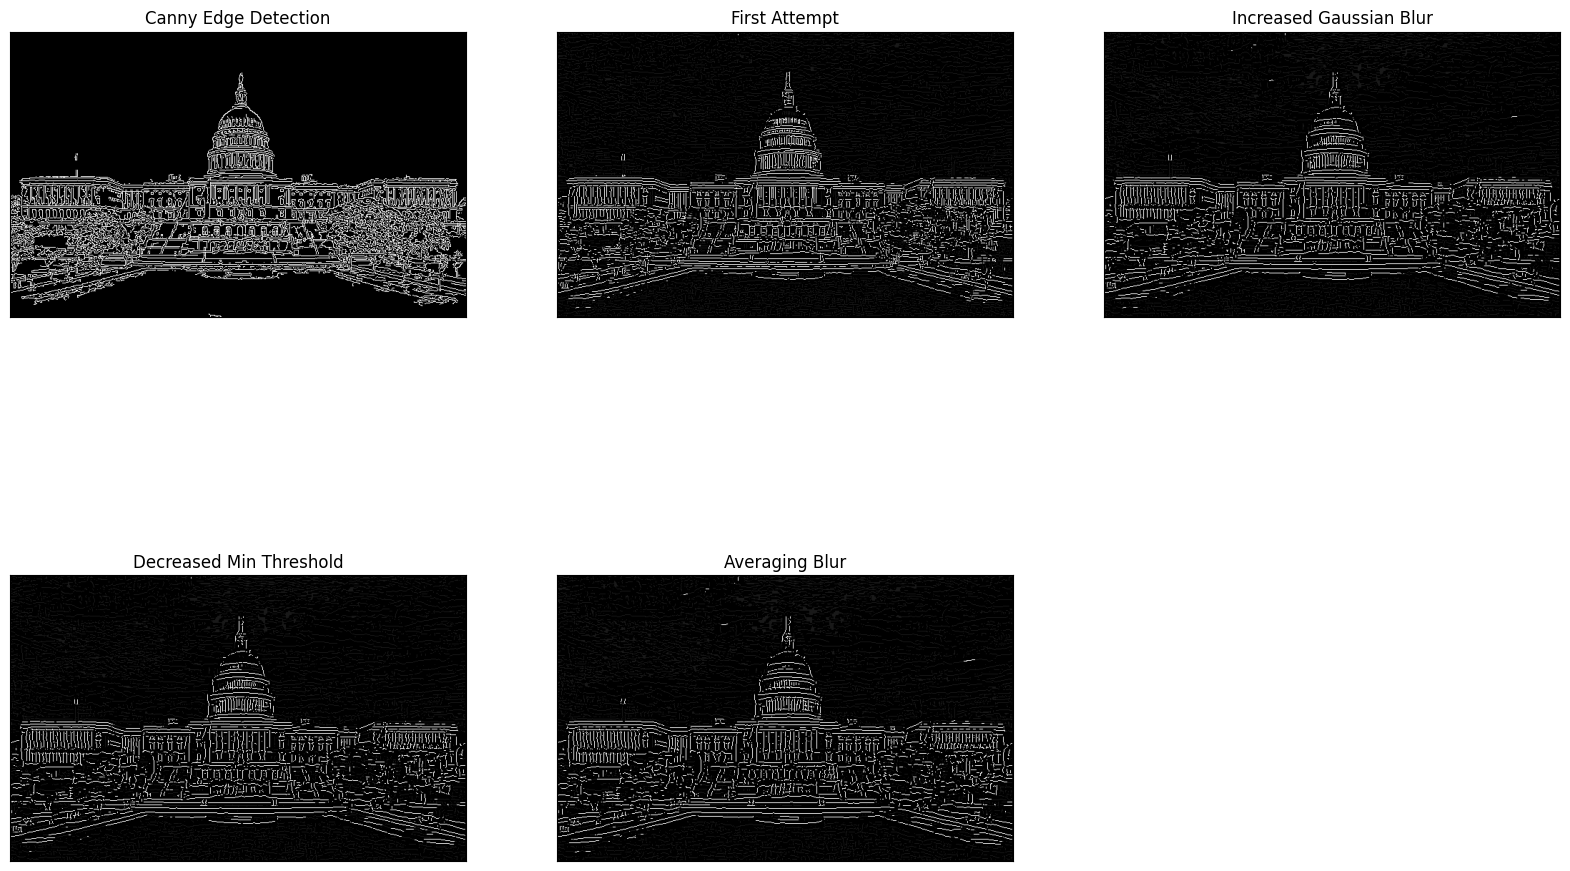

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.subplot(331),plt.imshow(Canny, cmap = 'gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])
plt.subplot(332), plt.imshow(final_edges, cmap = 'gray')
plt.title('First Attempt'), plt.xticks([]), plt.yticks([])
plt.subplot(333), plt.imshow(final_edges2, cmap = 'gray')
plt.title('Increased Gaussian Blur'), plt.xticks([]), plt.yticks([])
plt.subplot(334), plt.imshow(final_edges3, cmap = 'gray')
plt.title('Decreased Min Threshold'), plt.xticks([]), plt.yticks([])
plt.subplot(335), plt.imshow(final_edges4, cmap = 'gray')
plt.title('Averaging Blur'), plt.xticks([]), plt.yticks([])
plt.show()